## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [1]:
import os

model_save_path = "saved_model1"
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI", "INDI", "FOREIGN", "ORG"]
# cols = ["KOSPI", "KOSPI_VOL", "CR", "GOLD", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
cols = ["KOSPI", "KOSPI_HIGH", "KOSPI_LOW"]
len_x_ARMA = 30
len_y_nextday = 20
scale_method = "norm"

# 패키지 캐시 모두 지우기 (tf 등 이전에 남은 가비지가 영향을 미칠 수 있음)
for dir_ in ["/Users/hrdkdh/Documents/GitHub/predict/", "/Users/hrdkdh/venv/"]:
    os.system("find {} | grep -E '(__pycache__|\.pyc$|\pyo$)' | xargs rm -rf".format(dir_))

1-1) 데이터 크롤링

In [2]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=30, perPage=100)
# crawler.crawlData(cols, save=True)
crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled = df_crawled.loc[:2000]
df_crawled

,date,KOSPI,KOSPI_HIGH,KOSPI_LOW
0,2022-03-08,2629.31,2647.18,2605.81
1,2022-03-07,2651.31,2680.17,2644.10
2,2022-03-04,2713.43,2736.58,2702.34
3,2022-03-03,2747.08,2748.21,2726.35
4,2022-03-02,2703.52,2716.46,2692.24
...,...,...,...,...
1996,2014-01-22,1970.42,1970.42,1959.57
1997,2014-01-21,1963.89,1965.43,1949.56
1998,2014-01-20,1953.78,1955.28,1934.38
1999,2014-01-17,1944.48,1962.64,1943.13


1-2. 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols, scale_method, model_save_path)
dpp.sortByDate()
dpp.makeDiffRatio()
dpp.scalingForModeling()
dpp.makeAR(0, len_x_ARMA)
dpp.makeMA(2, len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)

In [4]:
#상관계수 보고 드랍하기
corr = dpp.df_corr.sort_values(by=["corr"], ascending=False)
remove_cols = corr.loc[(corr["corr"] < 0.5), "X"].to_list()
dpp.df.drop(columns=remove_cols, inplace=True)

In [5]:
#변수 선택하기
dpp.splitData()
# dpp.df.to_excel("processed_data.xlsx", index=False)
dpp.df

,date,KOSPI,KOSPI_HIGH,KOSPI_LOW,X_KOSPI_AR0,X_KOSPI_DIFF_RATIO_AR0,X_KOSPI_AR1,X_KOSPI_DIFF_RATIO_AR1,X_KOSPI_AR2,X_KOSPI_DIFF_RATIO_AR2,...,Y_KOSPI_nextday_11,Y_KOSPI_nextday_12,Y_KOSPI_nextday_13,Y_KOSPI_nextday_14,Y_KOSPI_nextday_15,Y_KOSPI_nextday_16,Y_KOSPI_nextday_17,Y_KOSPI_nextday_18,Y_KOSPI_nextday_19,Y_KOSPI_nextday_20
0,2014-03-04,-0.832267,-0.831053,-0.809909,-0.832267,-0.832267,-0.804419,-0.804419,-0.764147,-0.764147,...,-0.875514,-0.923314,-0.882726,-0.854799,-0.866117,-0.805419,-0.769464,-0.761489,-0.749354,-0.732587
1,2014-03-05,-0.787178,-0.795185,-0.763068,-0.787178,-0.787178,-0.832267,-0.832267,-0.804419,-0.804419,...,-0.923314,-0.882726,-0.854799,-0.866117,-0.805419,-0.769464,-0.761489,-0.749354,-0.732587,-0.718716
2,2014-03-06,-0.775650,-0.799571,-0.768662,-0.775650,-0.775650,-0.787178,-0.787178,-0.832267,-0.832267,...,-0.882726,-0.854799,-0.866117,-0.805419,-0.769464,-0.761489,-0.749354,-0.732587,-0.718716,-0.728060
3,2014-03-07,-0.778124,-0.778922,-0.767363,-0.778124,-0.778124,-0.775650,-0.775650,-0.787178,-0.787178,...,-0.854799,-0.866117,-0.805419,-0.769464,-0.761489,-0.749354,-0.732587,-0.718716,-0.728060,-0.742827
4,2014-03-10,-0.831451,-0.820350,-0.811633,-0.831451,-0.831451,-0.778124,-0.778124,-0.775650,-0.775650,...,-0.866117,-0.805419,-0.769464,-0.761489,-0.749354,-0.732587,-0.718716,-0.728060,-0.742827,-0.738589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,2022-01-27,0.905959,1.151105,0.944652,0.905959,0.905959,1.155357,1.155357,1.184705,1.184705,...,1.209158,1.247087,1.248219,1.246324,1.148908,1.182441,0.996269,1.069864,1.128877,1.140301
1946,2022-01-28,1.034540,1.009433,0.883788,1.034540,1.034540,0.905959,0.905959,1.155357,1.155357,...,1.247087,1.248219,1.246324,1.148908,1.182441,0.996269,1.069864,1.128877,1.140301,1.254957
1947,2022-02-03,1.151619,1.183684,1.178698,1.151619,1.151619,1.034540,1.034540,0.905959,0.905959,...,1.248219,1.246324,1.148908,1.182441,0.996269,1.069864,1.128877,1.140301,1.254957,1.166385
1948,2022-02-04,1.263328,1.226653,1.205446,1.263328,1.263328,1.151619,1.151619,1.034540,1.034540,...,1.246324,1.148908,1.182441,0.996269,1.069864,1.128877,1.140301,1.254957,1.166385,1.002875


1-3) 모델 훈련하고 생성

2022-03-09 20:24:42.998386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 20:24:42.998500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-09 20:24:43.094823: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 186)               0         
                                                                 
 dense (Dense)               (None, 512)               95744     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                             

2022-03-09 20:24:43.303816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-09 20:24:43.935204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료2000/2000(1999%) loss : 0.0013, mae : 0.0213, mse : 0.0013 / val_loss : 0.0081, val_mae : 0.0566, val_mse : 0.0081                              


2022-03-09 20:34:56.238175: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료


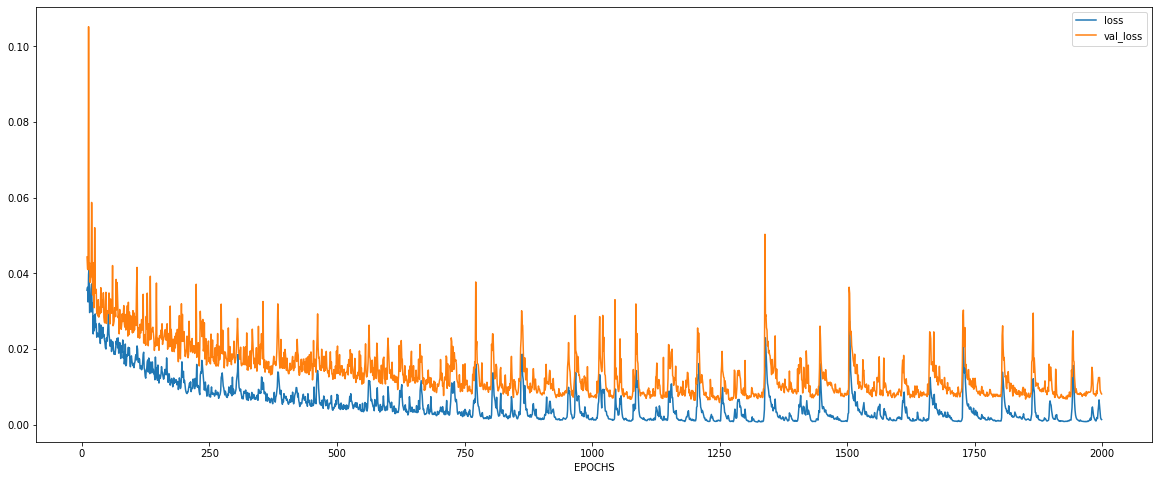

In [6]:
from kospi_predict import ModelMaker

maker = ModelMaker(
    dpp.y_list,
    dpp.df_train,
    dpp.df_test,
    perceptron_vol = 512,
    dense_vol = 5,
    activation_method = "relu",
    optimizer_str = "Adam",
    model_save_path = model_save_path)
maker.makeModel(EPOCHS=2000, learning_rate=0.001, save_by_checkpoint=True)

INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model1/assets
모델 저장 완료


,y_no,test_mae,test_mse
0,0,0.051983,0.005394
1,1,0.046249,0.004447
2,2,0.047498,0.005166
3,3,0.048198,0.004805
4,4,0.048134,0.005500
5,5,0.047382,0.004351
6,6,0.051606,0.006190
7,7,0.048583,0.005487
8,8,0.048951,0.005997
9,9,0.050664,0.006347


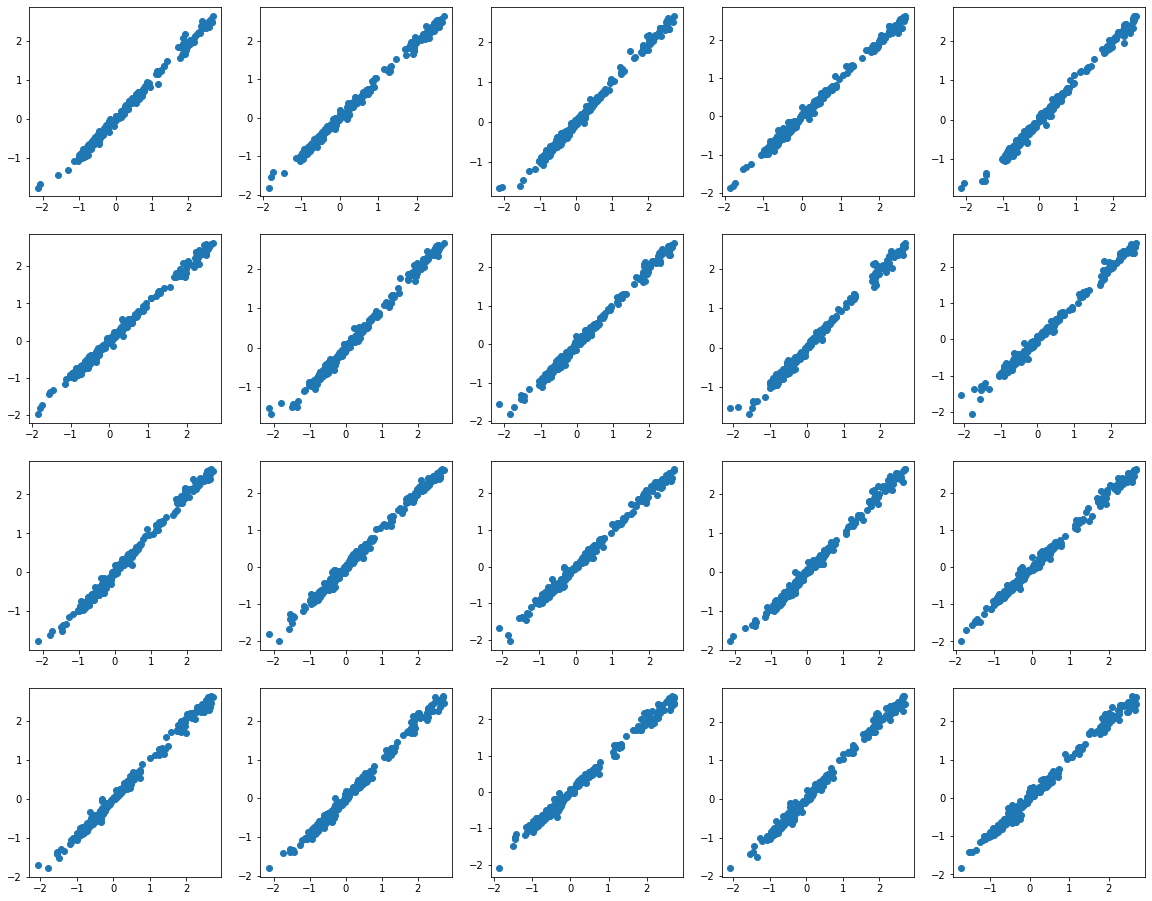

In [19]:
maker.saveModelByCheckpoint("1250")
maker.validateModel()
maker.test_error

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [20]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=100) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 데이터 수집중...
KOSPI_HIGH : 데이터 수집중...


,date,KOSPI,KOSPI_HIGH,KOSPI_LOW
0,2022-03-08,2622.40,2647.18,2605.81
1,2022-03-07,2651.31,2680.17,2644.10
2,2022-03-04,2713.43,2736.58,2702.34
3,2022-03-03,2747.08,2748.21,2726.35
4,2022-03-02,2703.52,2716.46,2692.24
...,...,...,...,...
5229,2001-01-08,586.65,587.91,572.48
5230,2001-01-05,580.85,581.41,555.40
5231,2001-01-04,558.02,567.16,550.91
5232,2001-01-03,521.43,524.58,510.70


2-2) 데이터 전처리

In [21]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred.loc[:100], cols, scale_method, model_save_path)
dpp_pred.sortByDate()
dpp_pred.makeDiffRatio()
dpp_pred.scalingForPredict()
dpp_pred.makeAR(0, len_x_ARMA)
dpp_pred.makeMA(2, len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

2-3) 예측

2022-03-09 20:40:15.454727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


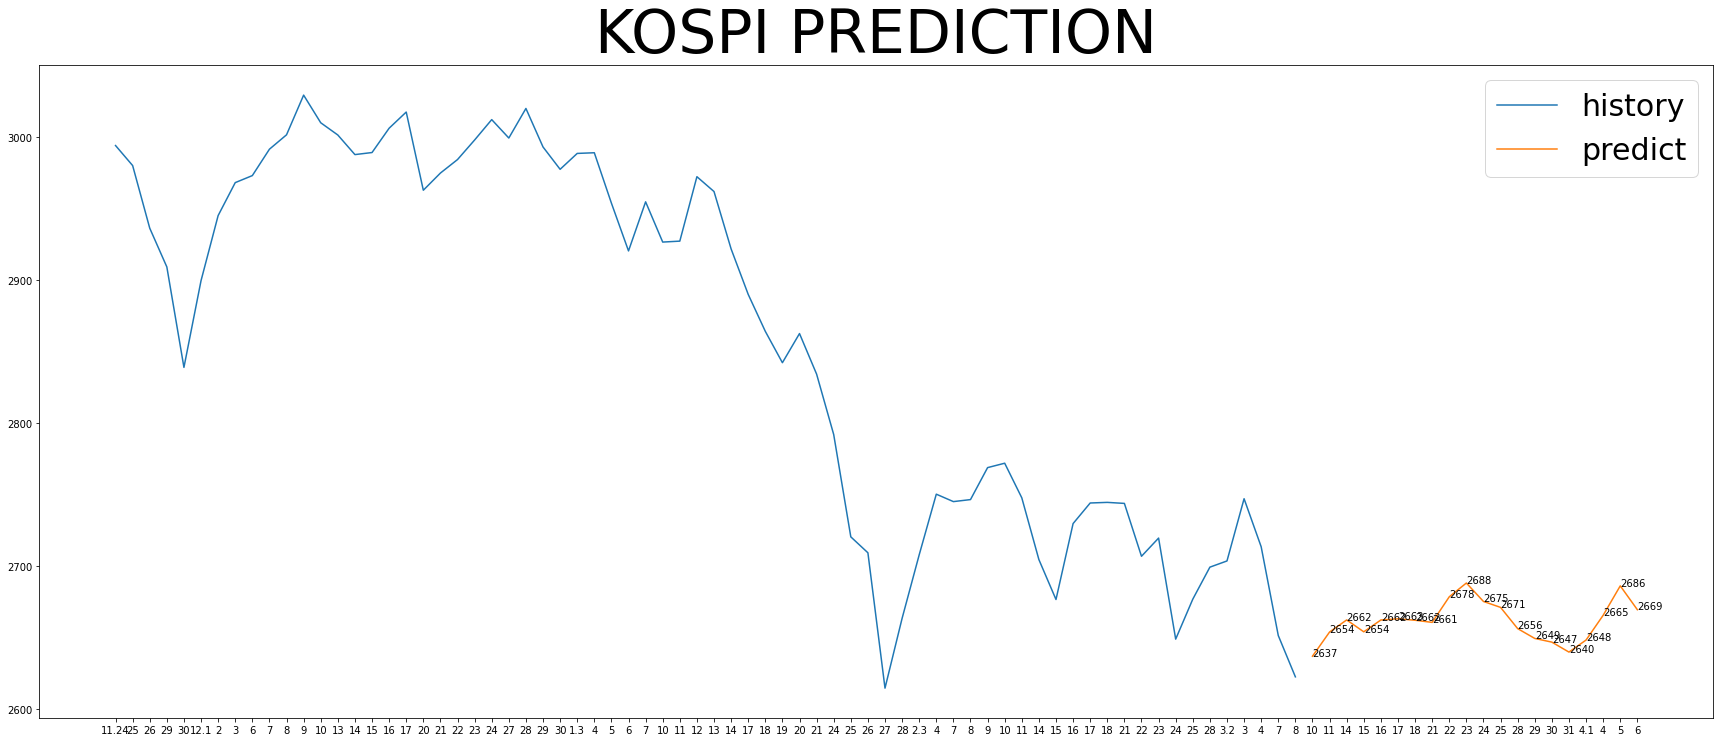

In [22]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df, scale_method = scale_method, model_save_path=model_save_path)
predictor.predict()
predictor.showPredictionPlot()

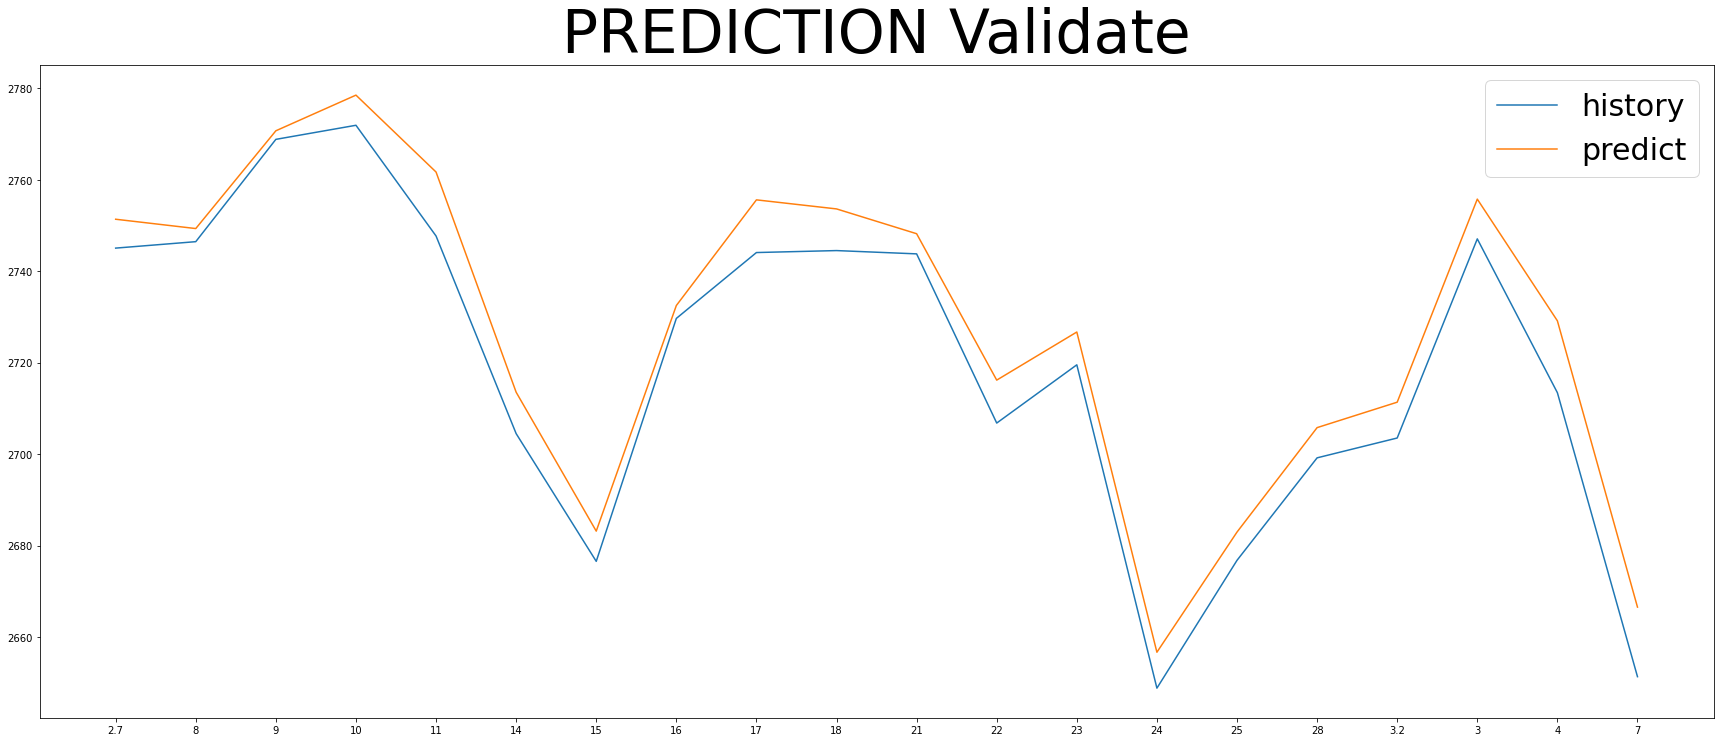

In [30]:
#실제 기록과 예측값을 비교하여 예측이 얼마나 잘 맞는지 확인한다
history_before = 22
df_result = predictor.predict(history_before)
predictor.showPredictionByHistory(df_result, history_before)

In [24]:
len(predictor.x_cols)
predictor.saveModelToJS()